In [1]:
import h5py
import numpy as np  
import matplotlib.pyplot as plt  
import os
import matplotlib.dates as mdates
from datetime import timedelta
import pandas as pd
from datetime import datetime
from astral.sun import sun
from astral import LocationInfo
import plotly.express as px

In [2]:
# Suggestion: rename the class to SLSTRFileAnalyzer
class SLSTRFileNameParser:
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_info = self.parse_file_name()

    def parse_file_name(self):
        components = [obj for obj in self.file_name.split('_') if obj!='']

        try:
            hdf = h5py.File("./ssts/day/"+self.file_name, 'r')
        except:
            hdf = h5py.File("./ssts/night/"+self.file_name, 'r')

        return {
            "filename": self.file_name,
            "mission_id": components[0],
            "data_source": components[1],
            "processing_level": components[2],
            "data_type_id": components[3],
            "start_time": datetime.strptime(components[4], "%Y%m%dT%H%M%S"),
            "stop_time": datetime.strptime(components[5], "%Y%m%dT%H%M%S"),
            "creation_date": datetime.strptime(components[6], "%Y%m%dT%H%M%S"),
            "instance_id": components[7]+'_'+components[8]+'_'+components[9]+'_'+components[10],
            "center_id": components[11],
            "class_id": components[12]+'_'+components[13]+'_'+components[14].split('.')[0],
            "file_extension": components[14].split('.')[1],
            "hdf_file": hdf
        }

    def get_file_info(self):
        return self.file_info

    def hdf_info(self):
        file = self.hdf_file
        print(file.keys())
        for key in file.keys():
            dset = file[key]
            print(key, "-->", dset.dtype, dset.shape)

    @staticmethod
    def generate_dataframe(file_names):
        data = []
        for counter, file_name in enumerate(file_names, start=1):
            parser = SLSTRFileNameParser(file_name)
            file_info = parser.get_file_info()
            file_info['counter'] = counter
            data.append(file_info)

        return pd.DataFrame(data)

    # not used
    @staticmethod
    def plot_gantt_chart(dataframe):
        # Sort DataFrame by start time for correct Gantt chart representation
        df = dataframe.sort_values(by=['start_time'])

        # Create Gantt chart
        fig = px.timeline(df, 
                          x_start='start_time', 
                          x_end='stop_time', 
                          y='counter', 
                          color='processing_level',
                          labels={'counter':'counter', 
                                  'mission_id': 'Mission ID', 
                                  'start_time': 'Start Time', 
                                  'stop_time': 'Stop Time'},
                          title='SLSTR Products Gantt Chart',
                          )

        # Add counter as the first element in the labels
        fig.update_layout(xaxis_title='Time', 
                          yaxis_title='Counter', 
                          showlegend=False)
        fig.update_traces(text=df.apply(lambda row: f"{row['counter']} - {row.name}", axis=1), hoverinfo='text+y')

        # Show the chart
        fig.show()

    @staticmethod
    def plot_scatterplot(dataframe):
        # Sort DataFrame by start time for correct Gantt chart representation
        df = dataframe.sort_values(by=['start_time'])
    
        plt.figure(figsize=(16*5, 9*5))
        
        df.plot(kind='scatter', x='start_time', y='counter', label='Start Time', c='green', s=10)
        df.plot(kind='scatter', x='stop_time', y='counter', label='Stop Time', c='red', s=10, ax=plt.gca())
    
        plt.title('SLSTR Products Scatter Plot')
        plt.xlabel('Date & Time')
        plt.ylabel('Counter')
        plt.legend()
    
        # dtime = pd.date_range(start = '2019-10-01', end = '2019-10-31', freq = '10min')
        dtime = pd.date_range(start = df.iloc[0]['start_time'].strftime('%Y-%m-%d'), end = df.iloc[-1]['stop_time'].strftime('%Y-%m-%d'), freq = '10min')
    
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 3))
        plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval = 1))
        plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation = 45 )
        plt.gca().set_xlim(dtime[0], dtime[-1])
    
        plt.show()

    @staticmethod
    def plot_image_matrix(dataframe, sort_by_time=False, display_time_in_title=False):
        if sort_by_time:
            dataframe = dataframe.sort_values(by=['start_time'])
        
        fig, axs = plt.subplots(10, 10)
        for i in range(100):
            dset = dataframe.iloc[i]['hdf_file']['bayes']
            data = np.asarray(dset)
            row,col = divmod(i, 10)
            axs[row][col].imshow(data, cmap='gray')

            if display_time_in_title:
                time = dataframe.iloc[i]['start_time'].strftime('%Y-%m-%d')[-2:]
                axs[row][col].title.set_text(time)
                
            axs[row][col].axis('off')

        plt.show()
        # plt.savefig('inference_image_matrix.png', dpi=500)

    

    def is_daytime(self, latitude, longitude):
        # Extracting the date and time from the start_time in the file_info
        datetime_obj = self.file_info["start_time"]

        # Getting the location information
        location = LocationInfo(latitude, longitude)

        # Calculating the sunrise and sunset times for the given date and location
        s = sun(location.observer, date=datetime_obj)

        # Checking if the timestamp is between sunrise and sunset
        return s["sunrise"] < datetime_obj < s["sunset"]

# Example usage with multiple file names
# file_names = [
#     "S3A_SL_2_LST____20151229T095534_20151229T114422_20160102T150019_6528_064_365______LN2_D_NT_001.SEN3",
#     "S3B_SL_1_RBT_BW_20160101T120000_20160101T130000_20160101T140000_GLOBAL___________LN2_R_NT_002.SEN3",
#     # Add more file names as needed
# ]

# Creating a DataFrame using the class method
# df = SLSTRFileNameParser.generate_dataframe(file_names)

# Displaying the DataFrame
# print(df)

# Plotting Gantt chart using the class method
# SLSTRFileNameParser.plot_gantt_chart(df)

# Checking if timestamps are daytime using the class method
# latitude = 37.7749  # Replace with the latitude of the specific location
# longitude = -122.4194  # Replace with the longitude of the specific location

# Assuming you want to check daytime for the first file in the DataFrame
# print(f"{df.iloc[0]['filename']} is daytime: {SLSTRFileNameParser(df.iloc[0]['filename']).is_daytime(latitude, longitude)}")

In [4]:
data_path1 = 'ssts/day/'
data_path2 = 'ssts/night/'
temp = os.listdir(data_path1) + os.listdir(data_path2)

tmp_df1 = SLSTRFileNameParser.generate_dataframe(os.listdir(data_path1))
tmp_df2 = SLSTRFileNameParser.generate_dataframe(os.listdir(data_path2))
tmp_df1['daylight'] = 'day'
tmp_df2['daylight'] = 'night'
tmp_df2['counter'] += 55
inference_df = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
# hdf_info(tmp_df.iloc[-1]['hdf_file'])
# inference_df

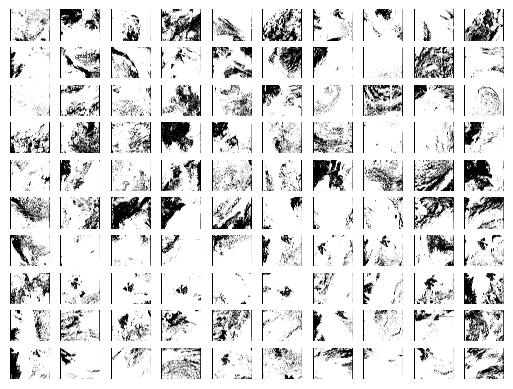

In [5]:
SLSTRFileNameParser.plot_image_matrix(inference_df)

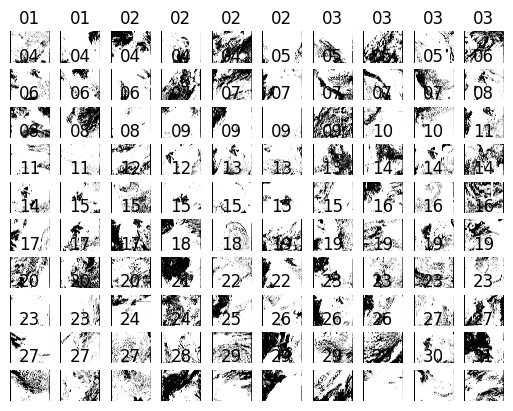

In [6]:
SLSTRFileNameParser.plot_image_matrix(inference_df, True, True)

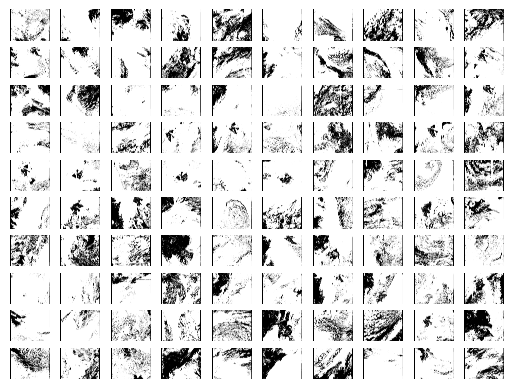

In [85]:
SLSTRFileNameParser.plot_image_matrix(inference_df, True, False)

# Search & Download using EUMDAC API, from here below
# Search & Download using EUMDAC API, from here below
# Search & Download using EUMDAC API, from here below

In [6]:
import eumdac
from IPython.core.display import HTML 
import requests
import shutil
import time

In [87]:
consumer_key = 'hvp_m5vrmucVy7qgIW8ZF3p3Z90a'
consumer_secret =  'mkAH3N18WrOaWfQYoaT0mjCoCyMa'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

try:
    print(f"This token '{token}' expires {token.expiration}")
except requests.exceptions.HTTPError as exc:
    print(f"Error when tryng the request to the server: '{exc}'")

This token '2e4c8107-69d5-34ee-958c-621f8d134104' expires 2023-11-29 21:04:03.260260


In [88]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:0615')

In [151]:
def search_SENTINEL3_product(df_entry):
    start_time = df_entry['start_time'].replace(second=0).to_pydatetime()
    start_time = start_time + timedelta(seconds=60)
    stop_time = start_time
    sat_type = None
    
    print('start_time:', start_time)
    
    if df_entry['mission_id']=='S3A':
        sat_type = 'Sentinel-3A'  
    else:
        raise Exception("mission_id (sat_type) unexpected, should be S3A")
    
    products = selected_collection.search(
        dtstart=start_time,
        dtend=stop_time,
        sat=sat_type
    )
    
    if len(products)!=1:
        raise Exception("Error 1: Search finds multiple products.")
        
    selected_product = None
    for product in products:
        try:
            if str(product)[:47]==df_entry['filename'][:47]:
                selected_product = product
                print(product)
                print('Verification Successful.')
            else:
                raise Exception("Error 2: Verfication Failed.")
        except eumdac.collection.CollectionError as error:
            print(f"Error related to the collection: '{error.msg}'")
        except requests.exceptions.ConnectionError as error:
            print(f"Error related to the connection: '{error.msg}'")
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")

    return selected_product

In [152]:
# Download two files: browse.jpg (raw image), xfdumanifest.xml (contains longitude, latitude)
def download_additional_data(selected_product):
    files = ['browse.jpg', str(selected_product)+'/xfdumanifest.xml']
    os.makedirs('ssts-additional-info/'+str(selected_product))
    
    try:
        for file in files:
            with selected_product.open(entry=file) as fsrc, open('ssts-additional-info/'+str(selected_product)+'/'+fsrc.name, mode='wb') as fdst:
                shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')
    except eumdac.product.ProductError as error:
        print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")
    except requests.exceptions.ConnectionError as error:
        print(f"Error related to the connection: '{error.msg}'")
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")

In [1]:
os.makedirs('ssts-additional-info/')

for i in range(len(inference_df)):
    # Find all 100 inference satellite image products
    selected_product = search_SENTINEL3_product(inference_df.iloc[i])

    # Download additional files
    download_additional_data(selected_product)

    print(i, '-------------------------------------------')
    

print('=========================================SUCCESS=========================================')
print('=========================================SUCCESS=========================================')
print('=========================================SUCCESS=========================================')

# Extract Geo-Coordinates (Latitude, Longitude), from here below
# Extract Geo-Coordinates (Latitude, Longitude), from here below
# Extract Geo-Coordinates (Latitude, Longitude), from here below

In [30]:
additional_data_path = 'ssts-additional-info/'
new_file_list = [file[:47] for file in os.listdir(additional_data_path)]
# new_file_list

In [37]:
def update_dataframe_with_new_filename(dataframe, additional_data_path):
    df = dataframe.copy()
    new_file_list = [file for file in os.listdir(additional_data_path)]
    new_file_list_short = [file[:47] for file in os.listdir(additional_data_path)]
    df['new_filename'] = [None for i in range(len(df))]
    
    for i in range(len(df)):
        for j in range(len(new_file_list_short)):
            if df.iloc[i]['filename'][:47] == new_file_list_short[j]:
                df.loc[i, 'new_filename'] = new_file_list[j]

    return df

In [41]:
def extract_coordinates(dataframe, additional_data_path):
    df = dataframe.copy()
    df['min_latitude'] = [None for i in range(len(df))]
    df['max_latitude'] = [None for i in range(len(df))]
    df['min_longitude'] = [None for i in range(len(df))]
    df['max_longitude'] = [None for i in range(len(df))]

    for i in range(len(df)):
        with open(additional_data_path + df.iloc[i]['new_filename'] + '/xfdumanifest.xml', 'r') as f:
            data = f.read()
        long_str = data.strip().split('gml:posList')[1][1:-2]
        long_list = long_str.strip().split(' ')
        long_list = [float(coor) for coor in long_list]
        list1 = long_list[::2]
        list2 = long_list[1::2]
        
        df.loc[i, 'min_latitude'] = min(list1)
        df.loc[i, 'max_latitude'] = max(list1)
        df.loc[i, 'min_longitude'] = min(list2)
        df.loc[i, 'max_longitude'] = max(list2)
        
    return df

In [40]:
inference_df = update_dataframe_with_new_filename(inference_df, 'ssts-additional-info/')
inference_df = extract_coordinates(inference_df, 'ssts-additional-info/')
inference_df

,filename,mission_id,data_source,processing_level,data_type_id,start_time,stop_time,creation_date,instance_id,center_id,class_id,file_extension,hdf_file,counter,daylight,new_filename,min_latitude,max_latitude,min_longitude,max_longitude
0,S3A_SL_1_RBT____20191001T113221_20191001T11352...,S3A,SL,1,RBT,2019-10-01 11:32:21,2019-10-01 11:35:21,2019-10-02 15:32:11,0179_050_023_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",1,day,S3A_SL_1_RBT____20191001T113221_20191001T11352...,49.3736,62.9199,-27.3277,1.10981
1,S3A_SL_1_RBT____20191002T124409_20191002T12470...,S3A,SL,1,RBT,2019-10-02 12:44:09,2019-10-02 12:47:09,2019-10-03 18:06:38,0180_050_038_1800,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",2,day,S3A_SL_1_RBT____20191002T124409_20191002T12470...,59.3336,73.3693,-44.6162,-4.17663
2,S3A_SL_1_RBT____20191002T124709_20191002T12500...,S3A,SL,1,RBT,2019-10-02 12:47:09,2019-10-02 12:50:09,2019-10-03 18:08:06,0179_050_038_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",3,day,S3A_SL_1_RBT____20191002T124709_20191002T12500...,49.3902,62.9367,-46.0283,-17.5778
3,S3A_SL_1_RBT____20191002T125609_20191002T12590...,S3A,SL,1,RBT,2019-10-02 12:56:09,2019-10-02 12:59:09,2019-10-03 18:12:26,0179_050_038_2520,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",4,day,S3A_SL_1_RBT____20191002T125609_20191002T12590...,18.1641,31.4999,-51.0993,-34.0545
4,S3A_SL_1_RBT____20191003T122059_20191003T12235...,S3A,SL,1,RBT,2019-10-03 12:20:59,2019-10-03 12:23:59,2019-10-04 17:35:32,0179_050_052_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",5,day,S3A_SL_1_RBT____20191003T122059_20191003T12235...,49.3862,62.9326,-39.4834,-11.0361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,S3A_SL_1_RBT____20191027T214628_20191027T21492...,S3A,SL,1,RBT,2019-10-27 21:46:28,2019-10-27 21:49:28,2019-10-29 01:32:17,0179_051_015_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",96,night,S3A_SL_1_RBT____20191027T214628_20191027T21492...,51.3203,64.9458,-23.332,6.80277
96,S3A_SL_1_RBT____20191029T003315_20191029T00361...,S3A,SL,1,RBT,2019-10-29 00:33:15,2019-10-29 00:36:15,2019-10-30 05:00:58,0179_051_031_0360,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",97,night,S3A_SL_1_RBT____20191029T003315_20191029T00361...,20.1914,33.5177,-49.4951,-32.1538
97,S3A_SL_1_RBT____20191029T223505_20191029T22380...,S3A,SL,1,RBT,2019-10-29 22:35:05,2019-10-29 22:38:05,2019-10-31 01:57:42,0179_051_044_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",98,night,S3A_SL_1_RBT____20191029T223505_20191029T22380...,51.3303,64.9386,-35.4784,-5.35265
98,S3A_SL_1_RBT____20191030T220854_20191030T22115...,S3A,SL,1,RBT,2019-10-30 22:08:54,2019-10-30 22:11:54,2019-11-01 02:57:13,0179_051_058_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",99,night,S3A_SL_1_RBT____20191030T220854_20191030T22115...,51.3245,64.9323,-28.9257,1.19417


In [55]:
def plot_raw_image_matrix(dataframe, additional_data_path, sort_by_time=False, display_time_in_title=False):
    if sort_by_time:
        dataframe = dataframe.sort_values(by=['start_time'])
    
    fig, axs = plt.subplots(10, 10)
    for i in range(100):
        image = img.imread(additional_data_path + dataframe.iloc[i]['new_filename'] + '/browse.jpg')
        row,col = divmod(i, 10)
        axs[row][col].imshow(image)

        if display_time_in_title:
            time = dataframe.iloc[i]['start_time'].strftime('%Y-%m-%d')[-2:]
            axs[row][col].title.set_text(time)
            
        axs[row][col].axis('off')

    # plt.show()
    plt.savefig('raw_inference_image_matrix.png', dpi=500)

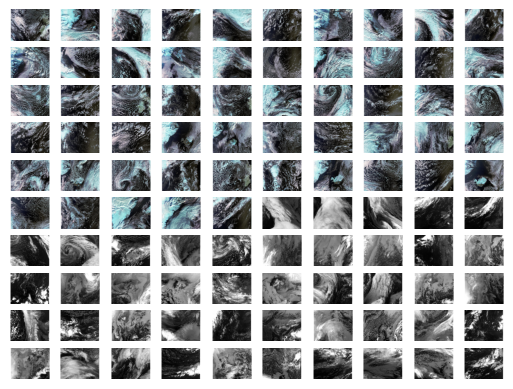

In [56]:
import matplotlib.image as img 

plot_raw_image_matrix(inference_df, 'ssts-additional-info/')

# Folium map generator, from here below
# Folium map generator, from here below
# Folium map generator, from here below

In [61]:
import folium
import time
from selenium import webdriver

In [67]:
# for i in range(len(inference_df)):
for i in range(100):
    
    latitude = [inference_df.iloc[i]['min_latitude'], inference_df.iloc[i]['max_latitude']]
    longitude = [inference_df.iloc[i]['min_longitude'], inference_df.iloc[i]['max_longitude']]
    print(inference_df.iloc[i]['start_time'])
    print(latitude, longitude)
    
    m = folium.Map(location=(sum(latitude)/len(latitude), sum(longitude)/len(longitude)), 
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False)
    folium.Rectangle([(latitude[0], longitude[0]), (latitude[1], longitude[1])]).add_to(m)
    m.fit_bounds([[latitude[0], longitude[0]], [latitude[1], longitude[1]]])

    delay=5
    fn='testmap.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    m.save(fn)
    
    browser = webdriver.Firefox()
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(delay)
    browser.save_screenshot('ssts-additional-info/' + inference_df.iloc[i]['new_filename'] + '/folium_map.png')
    browser.quit()
    print('=================================', 'Run', i, 'Completed','=================================')

2019-10-01 11:32:21
[49.3736, 62.9199] [-27.3277, 1.10981]
================================= Run 0 Completed =================================
2019-10-02 12:44:09
[59.3336, 73.3693] [-44.6162, -4.17663]
================================= Run 1 Completed =================================
2019-10-02 12:47:09
[49.3902, 62.9367] [-46.0283, -17.5778]
================================= Run 2 Completed =================================
2019-10-02 12:56:09
[18.1641, 31.4999] [-51.0993, -34.0545]
================================= Run 3 Completed =================================
2019-10-03 12:20:59
[49.3862, 62.9326] [-39.4834, -11.0361]
================================= Run 4 Completed =================================
2019-10-03 12:26:59
[28.6864, 41.999] [-42.7315, -23.7243]
================================= Run 5 Completed =================================
2019-10-04 11:48:48
[68.513, 83.7743] [-30.8868, 36.5925]
================================= Run 6 Completed ==============================